In [16]:
import numpy as np
import matplotlib.pyplot as plt 

In [17]:
coor_array=[]

long_coord = []
lat_coord = []

for i in range(2):
    long_coord.append(180*i)
for k in range(7):
    lat_coord.append(-15*k)

for lat in lat_coord:
    for long in long_coord:
        
        coor_array.append((long,lat))

In [53]:
sample_data = np.asarray(np.genfromtxt('../GS4/GS4_Trace{}'.format(1), dtype=float,
                         delimiter="\t", autostrip=True,skip_header=1, names =True))
length=len(sample_data)
print(sample_data.shape)

(600,)


In [144]:
raw_data_array=np.empty([180,2,600])
for i in range(180):
    raw_data = np.genfromtxt('../GS4/GS4_Trace{}'.format(i), dtype=float,
    delimiter="\t", autostrip=True,skip_header=1, names =True)
    raw_x=np.array([pair[0] for pair in raw_data])
    raw_y=np.array([pair[1] for pair in raw_data])
    raw_data_array[i,0,:]=raw_x
    raw_data_array[i,1,:]=raw_y

print(np.mean(raw_data_array[0,:,:],axis=1))

# convert to micro-volt and MHz
raw_data_array[:,1,:]=1e6*raw_data_array[:,1,:]
raw_data_array[:,0,:]=raw_data_array[:,0,:]/1e6

print(np.mean(raw_data_array[0,:,:],axis=1))

[1.42040167e+09 1.77182407e-05]
[1420.40166667   17.71824068]


In [145]:
sample_vx=raw_data_array[0,0,:]
sample_vy=raw_data_array[0,1,:]

In [146]:
# check the data is what we want
binw = 0.000003333333
ntbin=(sample_vx[length-1]-sample_vx[0])/binw
ntbin=ntbin+1
print(ntbin)

599001.1599000507


# Finding proportionality constant from sun data

In [147]:
# Finding proportionality constant from sun data
sunAmp = 2.3133616383333307e-05
TSun = 100000
viewSRT = .016
viewSun = 6.8e-5
TempPropConstant = (sunAmp*viewSRT)/(TSun*viewSun)
print(TempPropConstant)

5.4432038549019545e-08


# Convert to velocity 

In [148]:
xx=raw_data_array[:,0,:]
vy=raw_data_array[:,1,:]

def get_velocity(frequency):
    return(3e5*(1-1420.4/frequency))
xv=get_velocity(vx)

In [186]:
def get_dBm(milvolt):
    volt=milvolt/1e6
    return(10.*np.log10(volt*volt*1000./50))

def get_power(milvolt):
    volt=milvolt/1e6
    return(1e12*volt*volt/50)

In [187]:
yV=vy
yD=get_dBm(vy)
yP=get_power(vy)

In [177]:
#set the errors
shape=xx.shape
xxerror=np.full(shape,0.0)
yVerror=np.full(shape,0.03)
yDerror=np.full(shape,0.03)
yPerror=np.full(shape,0.03)
yTerror=np.full(shape,2.0)

In [195]:
#delete sharp peaks
ymax=5.25
mult=1.10

start=3
end=length-3


def del_peak(yP_vector):
    yP=np.copy(yP_vector)
    for i in np.arange(start,end):
        ytmp=yP[i]
        ytmpM=yP[i-2]
        ytmpP=yP[i+2]
        yavg=(ytmpM+ytmpP)/2.0
        if ytmp < (mult*yavg):
            pass
        else:
            yP[i]=yavg
            yP[i-1]=yavg
            yP[i+1]=yavg
#     print(np.all(yP==yP_vector))
    return(yP)

In [196]:
def test_del_peak():
    for i in range(180):
        yP_vector=yP[i,:]
        diff=yP_vector-del_peak(yP_vector)
        if np.sum(diff)!=0:
            print("it's working")
            break
                
test_del_peak()

it's working


In [198]:
yP_no_peak=np.apply_along_axis(del_peak,1,yP)

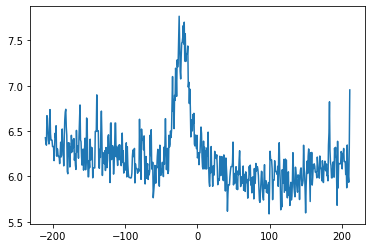

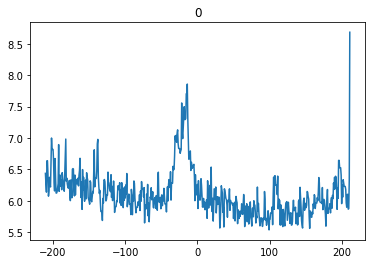

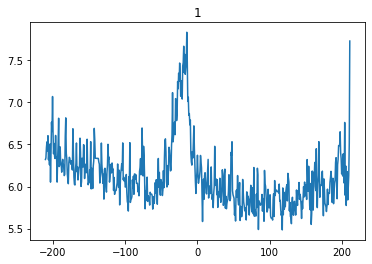

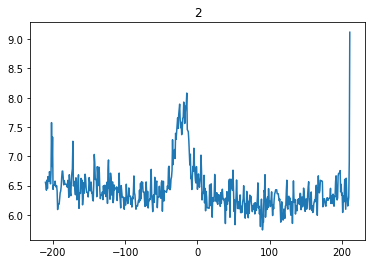

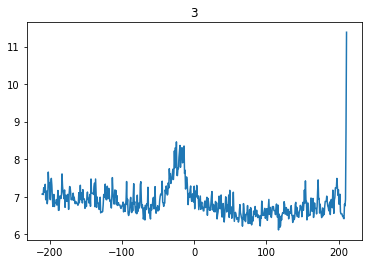

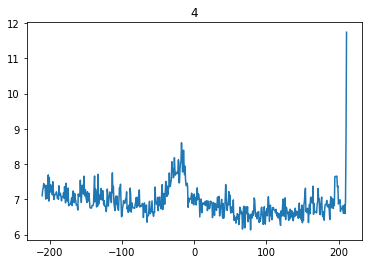

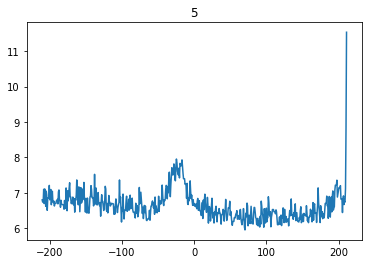

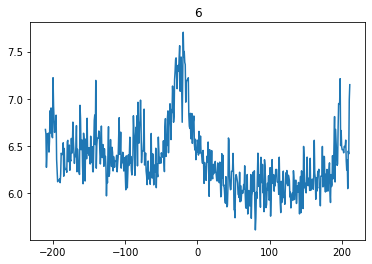

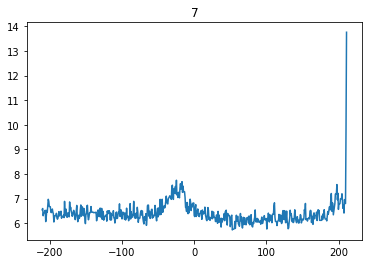

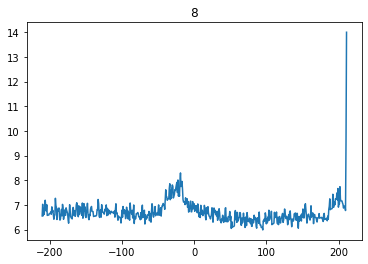

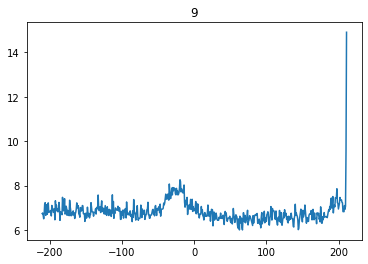

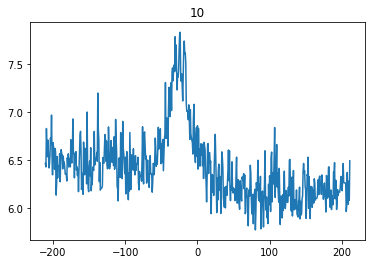

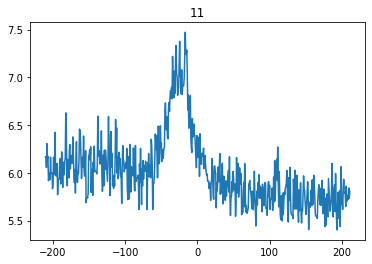

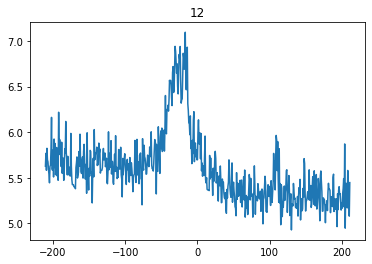

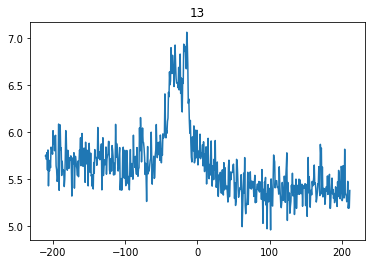

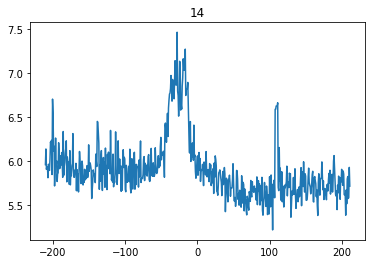

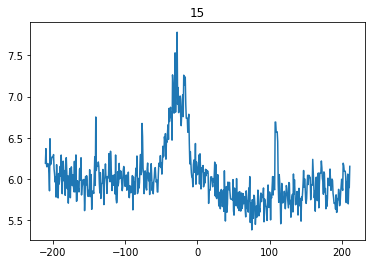

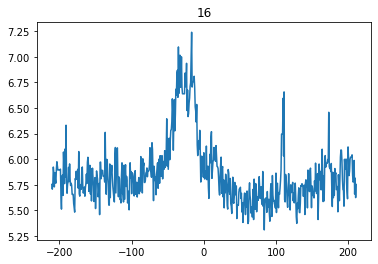

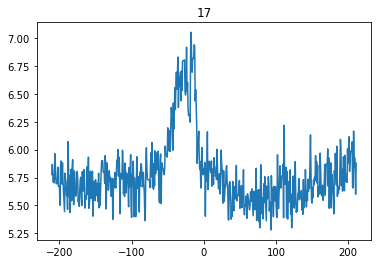

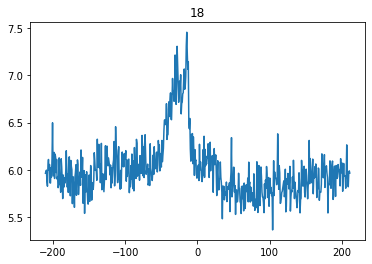

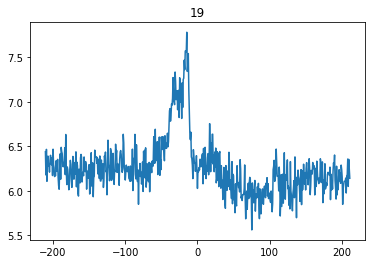

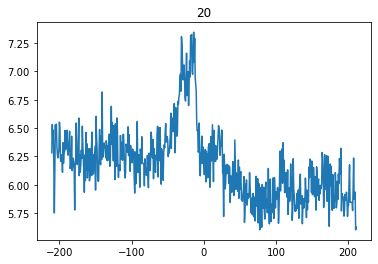

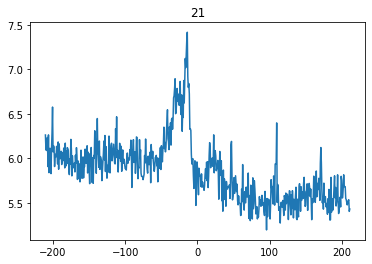

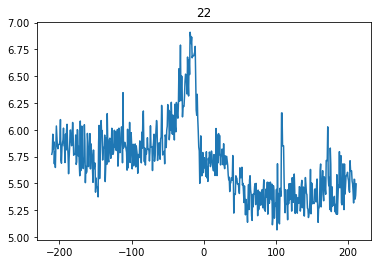

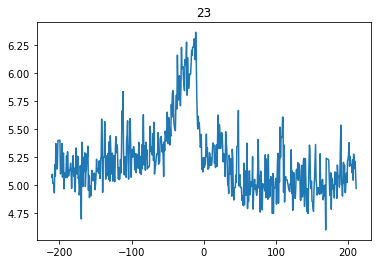

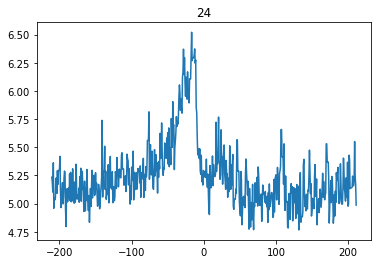

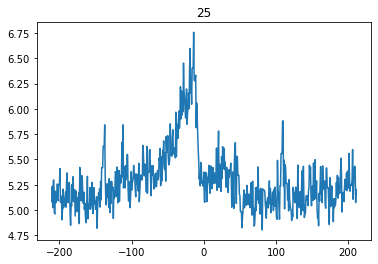

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [204]:
for i in range(180):
    x=xv[i,:]
    y=yP_no_peak[i,:]
    plt.plot(x,y)
    plt.show()
    plt.title(i)

In [200]:
#delete the signal region and fit the spectrum with second degree polynomial.
def del_signal_and_fit(xv_vec,yP_vec):
    XB=np.empty([1000])
    YB=np.empty([1000])
    x1del=-50
    x2del=50
    npoint=0
    for i in range(length):
        xtmp=xv[i]
        if (xtmp > x1del and xtmp < x2del):
            pass
        else:
            XB[npoint]=xtmp
            YB[npoint]=yP[i]
            npoint=npoint+1